## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [46]:
import pandas

In [47]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [48]:
# load the data - it is available open source and online

data = pd.read_csv('phpMYEkMl.csv')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [49]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [50]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [51]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [52]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [53]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [54]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [55]:
target = 'survived'

In [56]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O' and var!=target]

vars_cat = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [57]:
# first in numerical variables
vars_num_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]
vars_num_with_na

['age', 'fare']

In [58]:
# now in categorical variables
vars_cat_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]
vars_cat_with_na

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [59]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

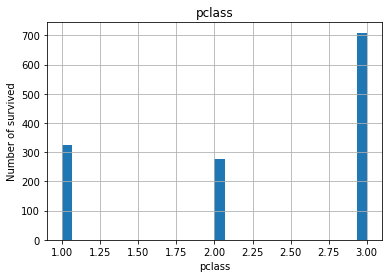

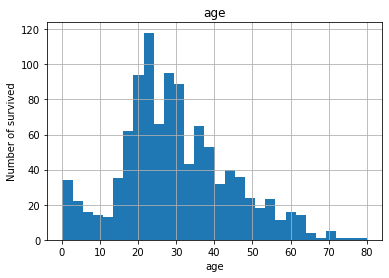

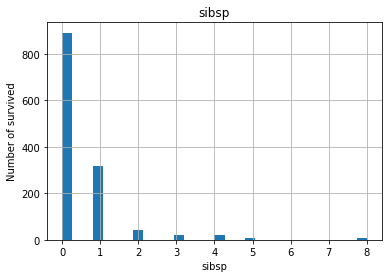

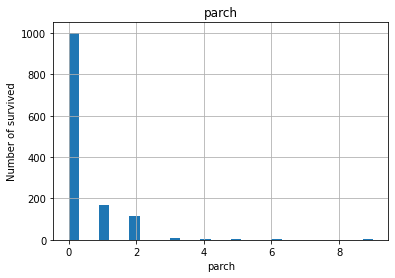

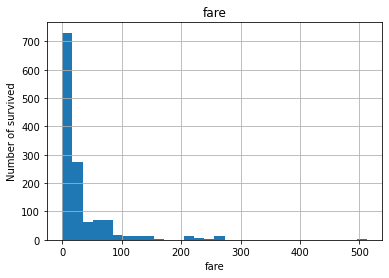

In [60]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of survived')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in vars_num:
    analyse_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [62]:
import re

X_train['cabin'] =  X_train['cabin'].str.extract(r"([A-Za-z]+)")
X_test['cabin'] =  X_test['cabin'].str.extract(r"([A-Za-z]+)")
X_train['cabin'].head
X_train['cabin'].unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [63]:
for var in vars_num_with_na:

    # replace NaN by median
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values in the engineered variables
X_train[vars_num_with_na].isnull().sum()
X_train.head

<bound method NDFrame.head of       pclass     sex      age  sibsp  parch      fare cabin embarked title  \
1118       3    male  25.0000      0      0    7.9250   NaN        S    Mr   
44         1  female  41.0000      0      0  134.5000     E        C  Miss   
1072       3    male  28.0000      0      0    7.7333   NaN        Q    Mr   
1130       3  female  18.0000      0      0    7.7750   NaN        S  Miss   
574        2    male  29.0000      1      0   21.0000   NaN        S    Mr   
...      ...     ...      ...    ...    ...       ...   ...      ...   ...   
763        3  female   0.1667      1      2   20.5750   NaN        S  Miss   
835        3    male  28.0000      0      0    8.0500   NaN        S    Mr   
1216       3  female  28.0000      0      0    7.7333   NaN        Q  Miss   
559        2  female  20.0000      0      0   36.7500   NaN        S  Miss   
684        3  female  32.0000      1      1   15.5000   NaN        Q   Mrs   

      age_na  fare_na  
1118     

### Replace Missing data in categorical variables with the string **Missing**

In [64]:
# replace missing values with new label: "Missing"

X_train[vars_cat_with_na] = X_train[vars_cat_with_na].fillna('Missing')
X_test[vars_cat_with_na] = X_test[vars_cat_with_na].fillna('Missing')

# check that we have no more missing values in the engineered variables
X_train[vars_cat_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

In [65]:
X_train.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

In [66]:
X_test.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

In [67]:
X_train[vars_cat].nunique()

sex         2
cabin       9
embarked    4
title       5
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [68]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)['survived'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    X_train_with_target = X_train.copy();
    X_train_with_target[target] = y_train;
    frequent_ls = find_frequent_labels(X_train_with_target, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [69]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [70]:
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

In [71]:
X_train.shape, X_test.shape

((1047, 11), (262, 11))

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [72]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [73]:
# Note that we have one less column in the test set
# this is because we had 1 less category in embarked.

# we need to add that category manually to the test set

X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


In [74]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,0,1,1,0,0,1,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,0,1,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,0,1,1,0,0
1150,3,28.0,0,0,14.5000,1,0,1,1,0,0,1,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,0,1,1,0,0


In [75]:
# we add 0 as values for all the observations, as Rare
# was not present in the test set

X_test['embarked_Rare'] = 0

In [76]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [77]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

In [78]:
X_train.shape, X_test.shape

((1047, 16), (262, 16))

In [79]:
# Note that now embarked_Rare will be at the end of the test set
# so in order to pass the variables in the same order, we will
# create a variables variable:

variables = [c  for c in X_train.columns]

variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_na',
 'fare_na',
 'sex_male',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [80]:
import warnings
warnings.simplefilter(action='ignore')

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[variables]) 

# transform the train and test set
X_train[variables] = scaler.transform(X_train[variables])

X_test[variables] = scaler.transform(X_test[variables])



## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [81]:
from sklearn.linear_model import LogisticRegression
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)


LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [83]:
predictions = model.predict(X_test[0:10])
score = model.score(X_test, y_test)
print(score)

0.6183206106870229


In [84]:
# to evaluate the models
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# to persist the model and the scaler
import joblib

# make predictions for train set
pred_train = model.predict(X_train)

# determine mse and rmse
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train)))))
print('train rmse: {}'.format(int(
    sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train))))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))
print()

# make predictions for test set
pred_test = model.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test)))))
print('test rmse: {}'.format(int(
    sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test))))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()


train mse: 1
train rmse: 1
train r2: -0.6182380216383305

test mse: 1
test rmse: 1
test r2: -0.617283950617284



In [86]:
# from solution
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8443431221020092
train accuracy: 0.6179560649474689

test roc-auc: 0.7976234567901234
test accuracy: 0.6183206106870229



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [39]:
p_train = 1*(pred_train > 0.5)
error_train = sum(abs(p_train - y_train)) / len(p_train) * 100
p_test = 1*(pred_test > 0.5)
error_test = sum(abs(p_test - y_test)) / len(p_test) * 100
print('error train: ', error_train)
print('error test: ', error_test)

error train:  38.2043935052531
error test:  38.16793893129771
